In [1]:
!pip install --upgrade ultralytics 
!pip install --upgrade -U ray[tune]

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import random
import yaml

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

# import IPython.display as display
from PIL import Image
import cv2

from ultralytics import YOLO
import torch

%matplotlib inline

!wandb disabled # use if you have Weights and Biases installed
os.environ['WANDB_MODE'] = 'disabled'

W&B disabled.


## YOLO Configuration

In [3]:
class CFG:
    DEBUG = False  # Set to True to make quick experiments
    FRACTION = 0.05 if DEBUG else 1.0  # Fraction of dataset to use
    SEED = 42

    # Classes
    CLASSES = ['door', 'openedDoor', 'cabinetDoor', 'refrigeratorDoor',
               'window', 'chair', 'table',
               'cabinet', 'couch', 'pole']
    NUM_CLASSES_TO_TRAIN = len(CLASSES)

    # Training parameters
    EPOCHS = 3 if DEBUG else 25
    BATCH_SIZE = 8
    BASE_MODEL = 'yolov9e'
    BASE_MODEL_WEIGHTS = f'{BASE_MODEL}.pt'
    EXP_NAME = f'ppe_css_{EPOCHS}_epochs'
    
    OPTIMIZER = 'AdamW'
    LR = 1e-5
    LR_FACTOR = 0.01
    WEIGHT_DECAY = 5e-4
    DROPOUT = 0.1
    PATIENCE = 10
    PROFILE = False
    LABEL_SMOOTHING = 0.1

    # Paths
    CUSTOM_DATASET_DIR = '/kaggle/input/indoor-object-detection/'
    OUTPUT_DIR = '/kaggle/working/'

In [4]:
dict_file = {
    'train': os.path.join(CFG.CUSTOM_DATASET_DIR, 'train'),
    'val': os.path.join(CFG.CUSTOM_DATASET_DIR, 'valid'),
    'test': os.path.join(CFG.CUSTOM_DATASET_DIR, 'test'),
    'nc': CFG.NUM_CLASSES_TO_TRAIN,
    'names': CFG.CLASSES
    }

with open(os.path.join(CFG.OUTPUT_DIR, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

In [5]:
### read yaml file created
def read_yaml_file(file_path = CFG.CUSTOM_DATASET_DIR):
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print("Error reading YAML:", e)
            return None

### print it with newlines
def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)

file_path = os.path.join(CFG.OUTPUT_DIR, 'data.yaml')
yaml_data = read_yaml_file(file_path)

if yaml_data:
    print_yaml_data(yaml_data)

names:
- door
- openedDoor
- cabinetDoor
- refrigeratorDoor
- window
- chair
- table
- cabinet
- couch
- pole
nc: 10
test: /kaggle/input/indoor-object-detection/test
train: /kaggle/input/indoor-object-detection/train
val: /kaggle/input/indoor-object-detection/valid



## Data exploration

#### Visualizing one image from the dataset

In [6]:
def display_image(image, print_info = True, hide_axis = False):
    if isinstance(image, str):  # Check if it's a file path
        img = Image.open(image)
        plt.imshow(img)
    elif isinstance(image, np.ndarray):  # Check if it's a NumPy array
        image = image[..., ::-1]  # BGR to RGB
        img = Image.fromarray(image)
        plt.imshow(img)
    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print('Type: ', type(img), '\n')
        print('Shape: ', np.array(img).shape, '\n')

    if hide_axis:
        plt.axis('off')

    plt.show()

Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (744, 1024, 3) 



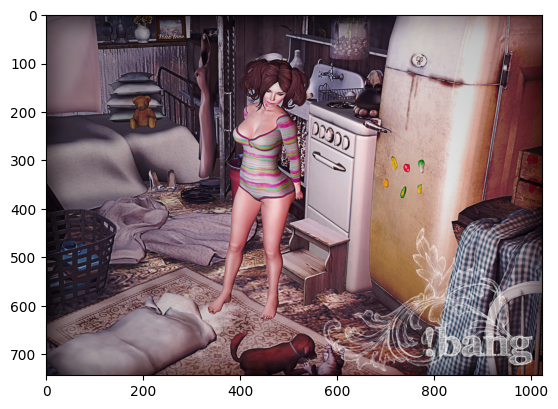

In [7]:
example_image_path = CFG.CUSTOM_DATASET_DIR + 'train/images/007821b7c578c94a.jpg'
display_image(example_image_path, print_info = True, hide_axis = False)

#### Visualizing several random images from the dataset

In [8]:
def plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED):
    
    random.seed(seed)

    # Get a list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg', '.gif'))]

    # Ensure that we have at least num_images files to choose from
    if len(image_files) < num_images:
        raise ValueError("Not enough images in the folder")

    # Randomly select num_images image files
    selected_files = random.sample(image_files, num_images)

    # Create a subplot grid
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    for i, file_name in enumerate(selected_files):
        # Open and display the image using PIL
        img = Image.open(os.path.join(folder_path, file_name))
        
        if num_rows == 1:
            ax = axes[i % num_cols]
        else:
            ax = axes[i // num_cols, i % num_cols]
        
        ax.imshow(img)
        ax.axis('off')
        # ax.set_title(file_name)

    # Remove empty subplots
    for i in range(num_images, num_rows * num_cols):
        if num_rows == 1:
            fig.delaxes(axes[i % num_cols])
        else:
            fig.delaxes(axes[i // num_cols, i % num_cols])

    plt.tight_layout()
    plt.show()

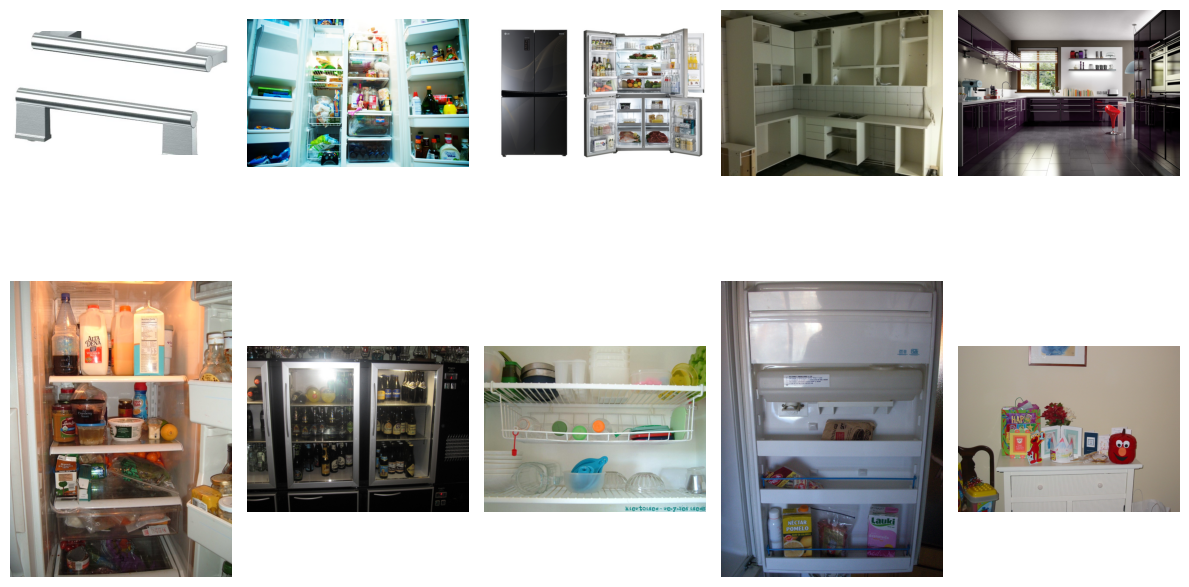

In [9]:
folder_path = CFG.CUSTOM_DATASET_DIR + 'train/images/'
plot_random_images_from_folder(folder_path, num_images=10, seed=CFG.SEED)

#### Define the main image properties

In [10]:
def get_image_properties(image_path):
    # Read the image file
    img = cv2.imread(image_path)

    # Check if the image file is read successfully
    if img is None:
        raise ValueError("Could not read image file")

    # Get image properties
    properties = {
        "width": img.shape[1],
        "height": img.shape[0],
        "channels": img.shape[2] if len(img.shape) == 3 else 1,
        "dtype": img.dtype,
    }

    return properties

In [11]:
img_properties = get_image_properties(example_image_path)
img_properties

{'width': 1024, 'height': 744, 'channels': 3, 'dtype': dtype('uint8')}

#### Count the number of instances for each class across all datasets

In [12]:
class_idx = {str(i): CFG.CLASSES[i] for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

class_stat = {}
data_len = {}
class_info = []

for mode in ['train', 'valid', 'test']:
    class_count = {CFG.CLASSES[i]: 0 for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

    path = os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'labels')

    for file in os.listdir(path):
        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1

    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

    class_info.append({'Mode': mode, **class_count, 'Data_Volume': data_len[mode]})

dataset_stats_df = pd.DataFrame(class_info)
with pd.option_context('display.max_columns', None): 
    display(dataset_stats_df)


,Mode,door,openedDoor,cabinetDoor,refrigeratorDoor,window,chair,table,cabinet,couch,pole,Data_Volume
0,train,309,448,332,187,105,165,138,22,68,14,1008
1,valid,63,99,85,39,24,30,28,1,13,4,230
2,test,25,42,1,49,38,41,44,31,18,3,104


#### Visualize the distribution of classes

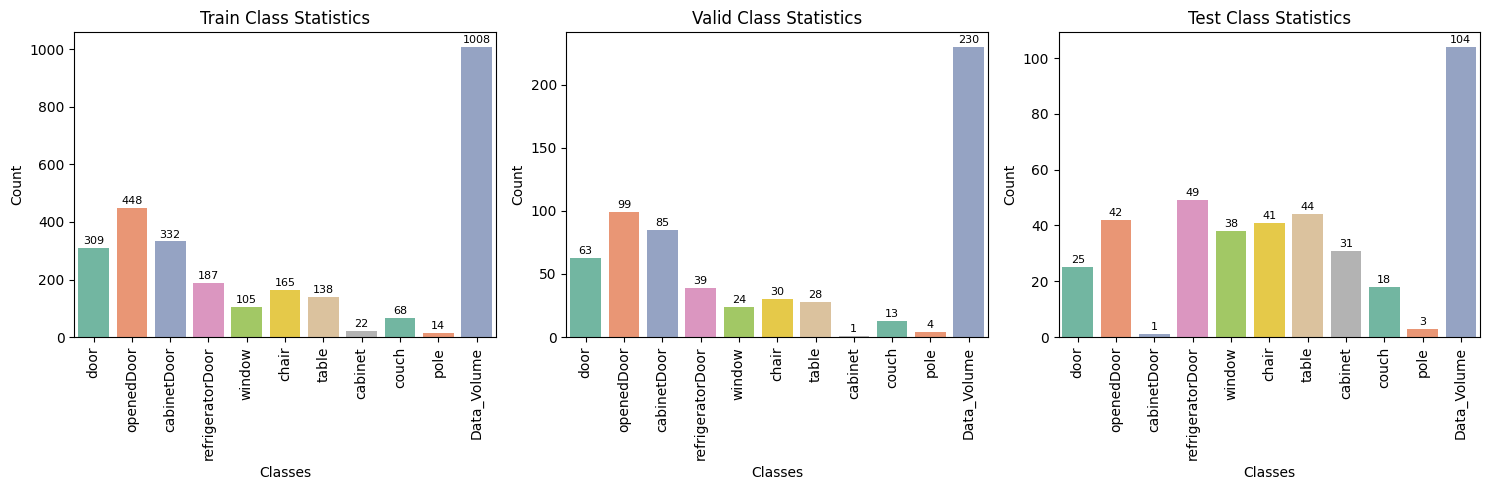

In [13]:
# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot vertical bar plots for each mode in subplots
for i, mode in enumerate(['train', 'valid', 'test']):
    sns.barplot(
        data=dataset_stats_df[dataset_stats_df['Mode'] == mode].drop(columns='Mode'),
        orient='v',
        ax=axes[i],
        palette='Set2'
    )
    
    axes[i].set_title(f'{mode.capitalize()} Class Statistics')
    axes[i].set_xlabel('Classes')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=90) 

    # Add annotations on top of each bar
    for p in axes[i].patches:
        axes[i].annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                         textcoords='offset points')

plt.tight_layout()
plt.show()

## Testing the base model

In [14]:
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

results = model.predict(
    source = example_image_path,

    classes = [0],
    conf = 0.30,
#     device = [0,1], # inference with dual GPU
    device = None, # inference with CPU
    imgsz = (img_properties['height'], img_properties['width']),

    save = True,
    save_txt = True,
    save_conf = True,
    exist_ok = True,
)


WARNING ⚠️ imgsz=[744, 1024] must be multiple of max stride 32, updating to [768, 1024]
image 1/1 /kaggle/input/indoor-object-detection/train/images/007821b7c578c94a.jpg: 768x1024 2 persons, 73.0ms
Speed: 2.8ms preprocess, 73.0ms inference, 169.6ms postprocess per image at shape (1, 3, 768, 1024)
Results saved to runs/detect/predict
1 label saved to runs/detect/predict/labels


Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (744, 1024, 3) 



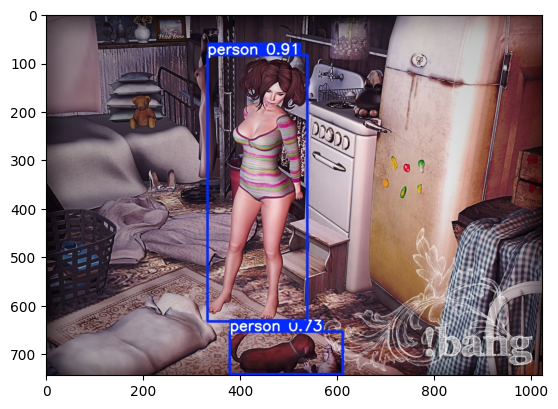

In [15]:
# check predictions with base model
example_image_inference_output = example_image_path.split('/')[-1]
display_image(f'runs/detect/predict/{example_image_inference_output}')

In [16]:
print('Model: ', CFG.BASE_MODEL_WEIGHTS)
print('Epochs: ', CFG.EPOCHS)
print('Batch: ', CFG.BATCH_SIZE)

Model:  yolov9e.pt
Epochs:  25
Batch:  8


In [17]:
torch.cuda.empty_cache()

## Model training

In [18]:
### Load pre-trained YOLO model
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

In [19]:
%%time

# train
model.train(
    data = os.path.join(CFG.OUTPUT_DIR, 'data.yaml'),
    task = 'detect',
    imgsz = 640,
    epochs = CFG.EPOCHS,
    batch = CFG.BATCH_SIZE,
    optimizer = CFG.OPTIMIZER,
    lr0 = CFG.LR,
    lrf = CFG.LR_FACTOR,
    weight_decay = CFG.WEIGHT_DECAY,
    dropout = CFG.DROPOUT,
    fraction = CFG.FRACTION,
    patience = CFG.PATIENCE,
    augment = True,
    mosaic = 0.8,
    mixup = 0.3,
    profile = CFG.PROFILE,
    label_smoothing = CFG.LABEL_SMOOTHING,
    name = f'{CFG.BASE_MODEL}_{CFG.EXP_NAME}',
    seed = CFG.SEED,    
    val = True,
    amp = True,    
    exist_ok = True,
    resume = False,
    device = [0], 
    verbose = False,
)

Ultralytics YOLOv8.2.103 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov9e.pt, data=/kaggle/working/data.yaml, epochs=25, time=None, patience=10, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=[0], workers=8, project=None, name=yolov9e_ppe_css_25_epochs, exist_ok=True, pretrained=True, optimizer=AdamW, verbose=False, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.1, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=Tru

100%|██████████| 755k/755k [00:00<00:00, 21.1MB/s]
2024-09-29 21:49:04,307	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-09-29 21:49:04,526	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


WARNING ⚠️ YOLOv9 `Silence` module is deprecated in favor of nn.Identity. Please delete local *.pt file and re-download the latest model checkpoint.
Overriding model.yaml nc=80 with nc=10

                   from  n    params  module                                       arguments                     
  0                  -1  1         0  torch.nn.modules.linear.Identity             []                            
  1                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  2                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  3                  -1  1    252160  ultralytics.nn.modules.block.RepNCSPELAN4    [128, 256, 128, 64, 2]        
  4                  -1  1    164352  ultralytics.nn.modules.block.ADown           [256, 256]                    
  5                  -1  1   1004032  ultralytics.nn.modules.block.RepNCSPELAN4    [256, 512, 256, 128, 2]       
  6          

100%|██████████| 6.25M/6.25M [00:00<00:00, 118MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/input/indoor-object-detection/train/labels... 1008 images, 120 backgrounds, 0 corrupt: 100%|██████████| 1012/1012 [00:03<00:00, 268.73it/s]

train: WARNING ⚠️ Cache directory /kaggle/input/indoor-object-detection/train is not writeable, cache not saved.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/input/indoor-object-detection/valid/labels... 230 images, 31 backgrounds, 0 corrupt: 100%|██████████| 230/230 [00:00<00:00, 268.69it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/indoor-object-detection/valid is not writeable, cache not saved.


Plotting labels to runs/detect/yolov9e_ppe_css_25_epochs/labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.937) with parameter groups 298 weight(decay=0.0), 310 weight(decay=0.0001), 309 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/yolov9e_ppe_css_25_epochs
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      12.6G      1.673      2.598      1.583         44        640: 100%|██████████| 127/127 [02:16<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.79it/s]

                   all        230       1289      0.552      0.193      0.168     0.0911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25        12G      1.503      1.857      1.437         94        640: 100%|██████████| 127/127 [02:11<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


                   all        230       1289      0.494      0.352      0.309      0.183

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      12.2G      1.499      1.792       1.44         43        640: 100%|██████████| 127/127 [02:10<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<00:00,  2.12it/s]


                   all        230       1289      0.552      0.336      0.337        0.2

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      12.2G      1.483      1.669      1.437         35        640: 100%|██████████| 127/127 [02:09<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<00:00,  2.13it/s]


                   all        230       1289      0.554      0.358      0.351      0.213

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      12.1G      1.428       1.55      1.421         79        640: 100%|██████████| 127/127 [02:09<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<00:00,  2.12it/s]

                   all        230       1289      0.528      0.341      0.384      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25        12G      1.383      1.519      1.405         50        640: 100%|██████████| 127/127 [02:09<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<00:00,  2.12it/s]


                   all        230       1289      0.561      0.376      0.361      0.221

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      12.2G      1.401      1.459      1.407         75        640: 100%|██████████| 127/127 [02:10<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<00:00,  2.13it/s]


                   all        230       1289      0.578      0.356       0.39      0.227

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      12.1G      1.371      1.459      1.408         94        640: 100%|██████████| 127/127 [02:09<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<00:00,  2.13it/s]


                   all        230       1289      0.484      0.417      0.397      0.237

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      12.2G      1.361      1.358      1.388         59        640: 100%|██████████| 127/127 [02:09<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<00:00,  2.13it/s]


                   all        230       1289      0.622      0.468      0.427      0.261

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      12.2G      1.325      1.302      1.356         62        640: 100%|██████████| 127/127 [02:09<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<00:00,  2.13it/s]


                   all        230       1289      0.507      0.383      0.411       0.24

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      12.1G      1.326      1.257      1.341         57        640: 100%|██████████| 127/127 [02:09<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<00:00,  2.13it/s]


                   all        230       1289      0.524      0.403      0.433      0.258

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      12.1G      1.309      1.255      1.346         47        640: 100%|██████████| 127/127 [02:09<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<00:00,  2.13it/s]


                   all        230       1289      0.505      0.555      0.476      0.303

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      12.1G      1.291      1.224      1.336         67        640: 100%|██████████| 127/127 [02:09<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<00:00,  2.13it/s]


                   all        230       1289      0.464      0.413      0.425      0.257

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      10.6G      1.279      1.175      1.329         86        640: 100%|██████████| 127/127 [02:09<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<00:00,  2.13it/s]


                   all        230       1289      0.427      0.468      0.451      0.278

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      12.2G      1.263      1.148      1.318         23        640: 100%|██████████| 127/127 [02:09<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<00:00,  2.13it/s]


                   all        230       1289      0.514      0.497      0.485      0.293
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      12.3G      1.139     0.9751      1.255          8        640: 100%|██████████| 127/127 [02:09<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<00:00,  2.12it/s]


                   all        230       1289      0.439      0.456      0.424      0.265

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      12.2G       1.13     0.8726      1.242         26        640: 100%|██████████| 127/127 [02:09<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<00:00,  2.13it/s]


                   all        230       1289      0.438       0.57      0.463      0.277

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      12.2G      1.107      0.793      1.219         29        640: 100%|██████████| 127/127 [02:09<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<00:00,  2.13it/s]


                   all        230       1289      0.555      0.411      0.457      0.276

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      12.1G      1.089     0.7587      1.224         25        640: 100%|██████████| 127/127 [02:09<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<00:00,  2.13it/s]


                   all        230       1289      0.499      0.401      0.447      0.278

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      12.1G      1.058     0.7301      1.202         15        640: 100%|██████████| 127/127 [02:09<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<00:00,  2.13it/s]


                   all        230       1289      0.461      0.498      0.457       0.28

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      12.1G      1.043     0.6919      1.195         10        640: 100%|██████████| 127/127 [02:09<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<00:00,  2.14it/s]


                   all        230       1289      0.526      0.501      0.532      0.291

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      12.1G      1.023     0.6761      1.175         12        640: 100%|██████████| 127/127 [02:09<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<00:00,  2.13it/s]


                   all        230       1289      0.476       0.44      0.442      0.266
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 12, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

22 epochs completed in 0.870 hours.
Optimizer stripped from runs/detect/yolov9e_ppe_css_25_epochs/weights/last.pt, 117.3MB
Optimizer stripped from runs/detect/yolov9e_ppe_css_25_epochs/weights/best.pt, 117.3MB

Validating runs/detect/yolov9e_ppe_css_25_epochs/weights/best.pt...
Ultralytics YOLOv8.2.103 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv9e summary (fused): 687 layers, 57,384,110 parameters, 0 gradients, 189.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:15<00:00,  1.01s/it]


                   all        230       1289      0.579      0.482      0.463      0.299
Speed: 0.2ms preprocess, 61.7ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/yolov9e_ppe_css_25_epochs
CPU times: user 40min 5s, sys: 13min 20s, total: 53min 25s
Wall time: 53min 9s


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d1664118d60>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0

#### Save the trained model weights

In [20]:
# Export the model
model.export(
    format = 'onnx', # openvino, onnx, engine, tflite
    imgsz = (img_properties['height'], img_properties['width']),
    half = False,
    int8 = False,
    simplify = False,
    nms = False,
)

Ultralytics YOLOv8.2.103 🚀 Python-3.10.14 torch-2.4.0 CPU (Intel Xeon 2.00GHz)
WARNING ⚠️ imgsz=[744, 1024] must be multiple of max stride 32, updating to [768, 1024]
YOLOv9e summary (fused): 687 layers, 57,384,110 parameters, 0 gradients, 189.2 GFLOPs

PyTorch: starting from 'runs/detect/yolov9e_ppe_css_25_epochs/weights/best.pt' with input shape (1, 3, 768, 1024) BCHW and output shape(s) (1, 14, 16128) (111.8 MB)

ONNX: starting export with onnx 1.16.2 opset 19...
ONNX: export success ✅ 8.4s, saved as 'runs/detect/yolov9e_ppe_css_25_epochs/weights/best.onnx' (219.5 MB)

Export complete (19.0s)
Results saved to /kaggle/working/runs/detect/yolov9e_ppe_css_25_epochs/weights
Predict:         yolo predict task=detect model=runs/detect/yolov9e_ppe_css_25_epochs/weights/best.onnx imgsz=768,1024  
Validate:        yolo val task=detect model=runs/detect/yolov9e_ppe_css_25_epochs/weights/best.onnx imgsz=768,1024 data=/kaggle/working/data.yaml  WARNING ⚠️ non-PyTorch val requires square images,

'runs/detect/yolov9e_ppe_css_25_epochs/weights/best.onnx'

## Results analysis

#### Save paths to all result images

In [21]:
results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'batch' not in i
]

results_paths

['/kaggle/working/runs/detect/yolov9e_ppe_css_25_epochs/confusion_matrix.png',
 '/kaggle/working/runs/detect/yolov9e_ppe_css_25_epochs/PR_curve.png',
 '/kaggle/working/runs/detect/yolov9e_ppe_css_25_epochs/R_curve.png',
 '/kaggle/working/runs/detect/yolov9e_ppe_css_25_epochs/P_curve.png',
 '/kaggle/working/runs/detect/yolov9e_ppe_css_25_epochs/confusion_matrix_normalized.png',
 '/kaggle/working/runs/detect/yolov9e_ppe_css_25_epochs/F1_curve.png',
 '/kaggle/working/runs/detect/yolov9e_ppe_css_25_epochs/results.png',
 '/kaggle/working/runs/detect/yolov9e_ppe_css_25_epochs/labels.jpg',
 '/kaggle/working/runs/detect/yolov9e_ppe_css_25_epochs/labels_correlogram.jpg']

#### Review the obtained results

/kaggle/working/runs/detect/yolov9e_ppe_css_25_epochs/F1_curve.png


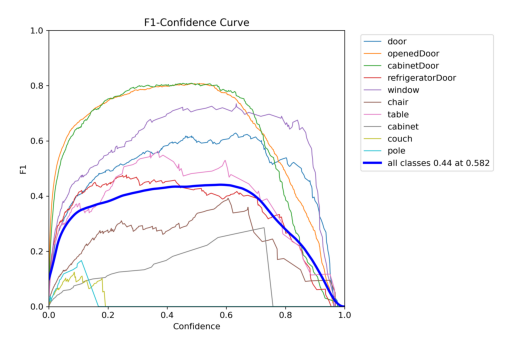



/kaggle/working/runs/detect/yolov9e_ppe_css_25_epochs/PR_curve.png


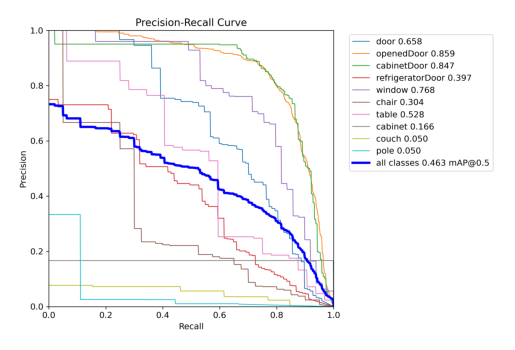



/kaggle/working/runs/detect/yolov9e_ppe_css_25_epochs/P_curve.png


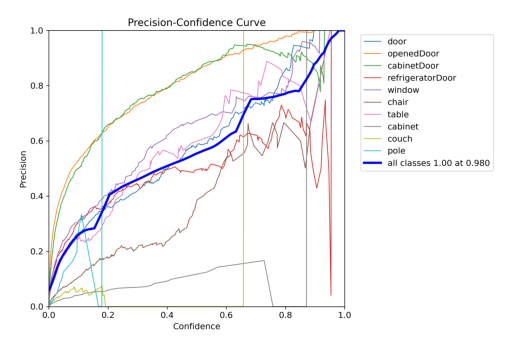



/kaggle/working/runs/detect/yolov9e_ppe_css_25_epochs/R_curve.png


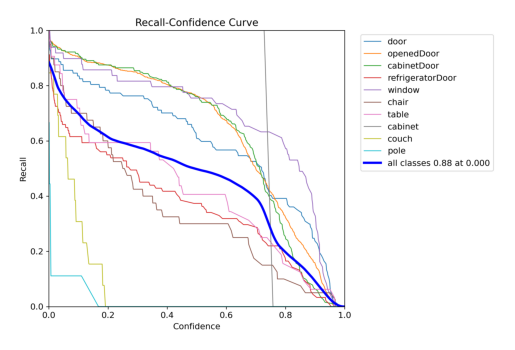



/kaggle/working/runs/detect/yolov9e_ppe_css_25_epochs/confusion_matrix.png


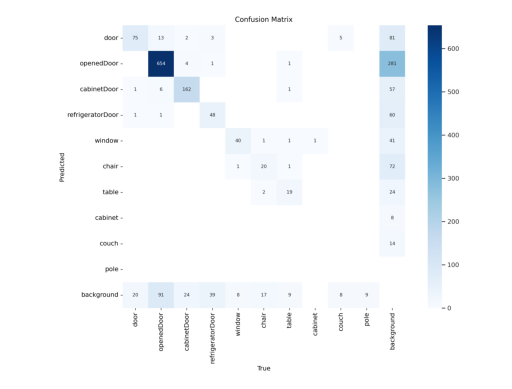



/kaggle/working/runs/detect/yolov9e_ppe_css_25_epochs/confusion_matrix_normalized.png


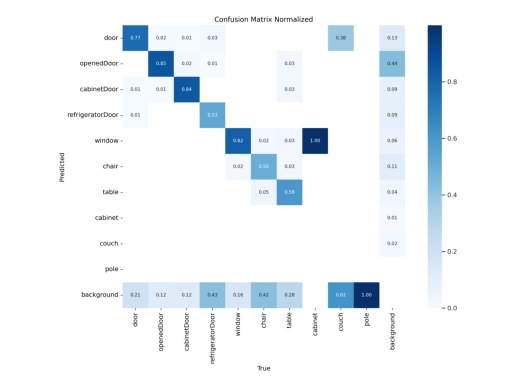



/kaggle/working/runs/detect/yolov9e_ppe_css_25_epochs/labels.jpg


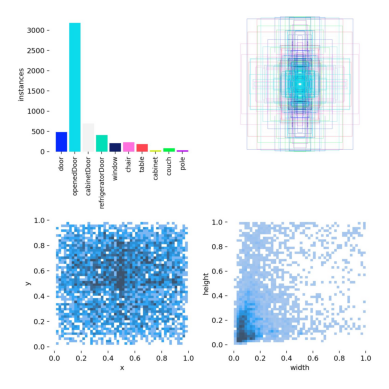



/kaggle/working/runs/detect/yolov9e_ppe_css_25_epochs/labels_correlogram.jpg


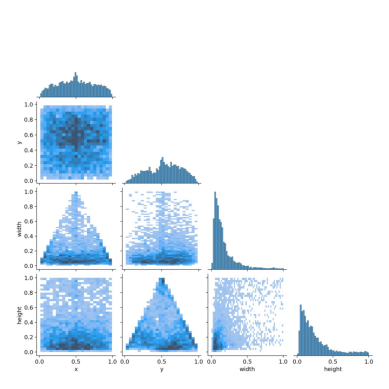



/kaggle/working/runs/detect/yolov9e_ppe_css_25_epochs/results.png


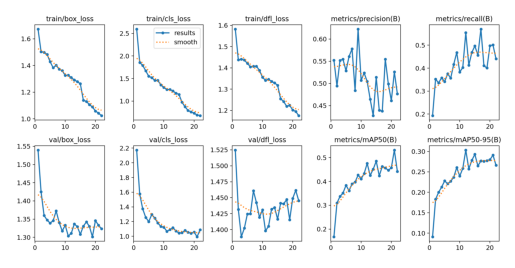

In [22]:
for file in sorted(results_paths):
    print(file)
    display_image(file, print_info = False, hide_axis = True)
    print('\n')

#### Output metrics for all epochs

In [23]:
df = pd.read_csv(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/results.csv')
df = df.rename(columns=lambda x: x.replace(" ", ""))
df.to_csv(f'{CFG.OUTPUT_DIR}training_log_df.csv', index=False)
df

,epoch,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,1.6735,2.59800,1.5827,0.55228,0.19287,0.16779,0.09109,1.5397,2.17300,1.5246,0.066962,0.000033,0.000033
1,2,1.5035,1.85670,1.4375,0.49433,0.35206,0.30914,0.18291,1.4252,1.57670,1.4317,0.033660,0.000064,0.000064
2,3,1.4991,1.79190,1.4404,0.55192,0.33600,0.33693,0.19995,1.3598,1.37210,1.3888,0.000356,0.000093,0.000093
3,4,1.4831,1.66950,1.4367,0.55436,0.35786,0.35144,0.21274,1.3473,1.25560,1.4022,0.000090,0.000090,0.000090
4,5,1.4282,1.55050,1.4211,0.52833,0.34120,0.38390,0.22790,1.3390,1.19930,1.4246,0.000087,0.000087,0.000087
5,6,1.3828,1.51920,1.4049,0.56074,0.37586,0.36106,0.22087,1.3457,1.29600,1.4248,0.000084,0.000084,0.000084
6,7,1.4013,1.45870,1.4071,0.57770,0.35624,0.38955,0.22688,1.3725,1.24670,1.4608,0.000081,0.000081,0.000081
7,8,1.3715,1.45860,1.4078,0.48386,0.41663,0.39750,0.23693,1.3404,1.18030,1.4423,0.000078,0.000078,0.000078
8,9,1.3611,1.35840,1.3880,0.62246,0.46802,0.42673,0.26056,1.3172,1.13240,1.4192,0.000074,0.000074,0.000074
9,10,1.3254,1.30240,1.3556,0.50695,0.38317,0.41056,0.23968,1.3332,1.12320,1.4311,0.000071,0.000071,0.000071


In [24]:
df.columns = df.columns.str.strip()

print('*'*50)
print('\nBest Training Box loss: ', df['train/box_loss'].min(), ', on epoch: ', df['train/box_loss'].argmin() + 1, '\n')
print('\nBest Validation Box loss: ', df['val/box_loss'].min(), ', on epoch: ', df['val/box_loss'].argmin() + 1, '\n')

print('='*50)
print('\nBest Training Cls loss: ', df['train/cls_loss'].min(), ', on epoch: ', df['train/cls_loss'].argmin() + 1, '\n')
print('\nBest Validation Cls loss: ', df['val/cls_loss'].min(), ', on epoch: ', df['val/cls_loss'].argmin() + 1, '\n')

print('='*50)
print('\nBest Training DFL loss: ', df['train/dfl_loss'].min(), ', on epoch: ', df['train/dfl_loss'].argmin() + 1, '\n')
print('\nBest Validation DFL loss: ', df['val/dfl_loss'].min(), ', on epoch: ', df['val/dfl_loss'].argmin() + 1, '\n')

**************************************************

Best Training Box loss:  1.0232 , on epoch:  22 


Best Validation Box loss:  1.3014 , on epoch:  19 


Best Training Cls loss:  0.67612 , on epoch:  22 


Best Validation Cls loss:  0.99278 , on epoch:  21 


Best Training DFL loss:  1.175 , on epoch:  22 


Best Validation DFL loss:  1.3888 , on epoch:  3 



#### Output key metrics

In [25]:
# Function to display model performance metrics
def evaluate_model_performance(model):
    # Get validation results
    results = model.val()
    
    # Display metrics for each class
    class_names = results.names
    
    metrics_table = pd.DataFrame({
        "Class": [class_names[i] for i in range(len(class_names))],
        "Precision": results.box.p,
        "Recall": results.box.r,
        "F1-score": results.box.f1
    })

    print(f"\nMetrics for each class:")
    print(metrics_table)

    mAP_50 = results.box.map50
    mAP_50_95 = results.box.map
    precision = results.box.mp
    recall = results.box.mr
    f1_score = np.mean(results.box.f1)

    print(f"\nmAP50: {mAP_50:.4f}")
    print(f"mAP50-95: {mAP_50_95:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1_score:.4f}")

evaluate_model_performance(model)

Ultralytics YOLOv8.2.103 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv9e summary (fused): 687 layers, 57,384,110 parameters, 0 gradients, 189.2 GFLOPs


val: Scanning /kaggle/input/indoor-object-detection/valid/labels... 230 images, 31 backgrounds, 0 corrupt: 100%|██████████| 230/230 [00:00<00:00, 686.40it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/indoor-object-detection/valid is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:18<00:00,  1.58it/s]


                   all        230       1289      0.581      0.477      0.465      0.302
Speed: 0.2ms preprocess, 72.1ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/yolov9e_ppe_css_25_epochs

Metrics for each class:
              Class  Precision    Recall  F1-score
0              door   0.607317  0.567010  0.586472
1        openedDoor   0.887144  0.709021  0.788144
2       cabinetDoor   0.885735  0.726722  0.798388
3  refrigeratorDoor   0.509021  0.329670  0.400169
4            window   0.695570  0.734694  0.714597
5             chair   0.443900  0.300000  0.358032
6             table   0.639143  0.406250  0.496755
7           cabinet   0.139621  1.000000  0.245031
8             couch   0.000000  0.000000  0.000000
9              pole   1.000000  0.000000  0.000000

mAP50: 0.4648
mAP50-95: 0.3019
Precision: 0.5807
Recall: 0.4773
F1-score: 0.4388


#### Display loss graphs

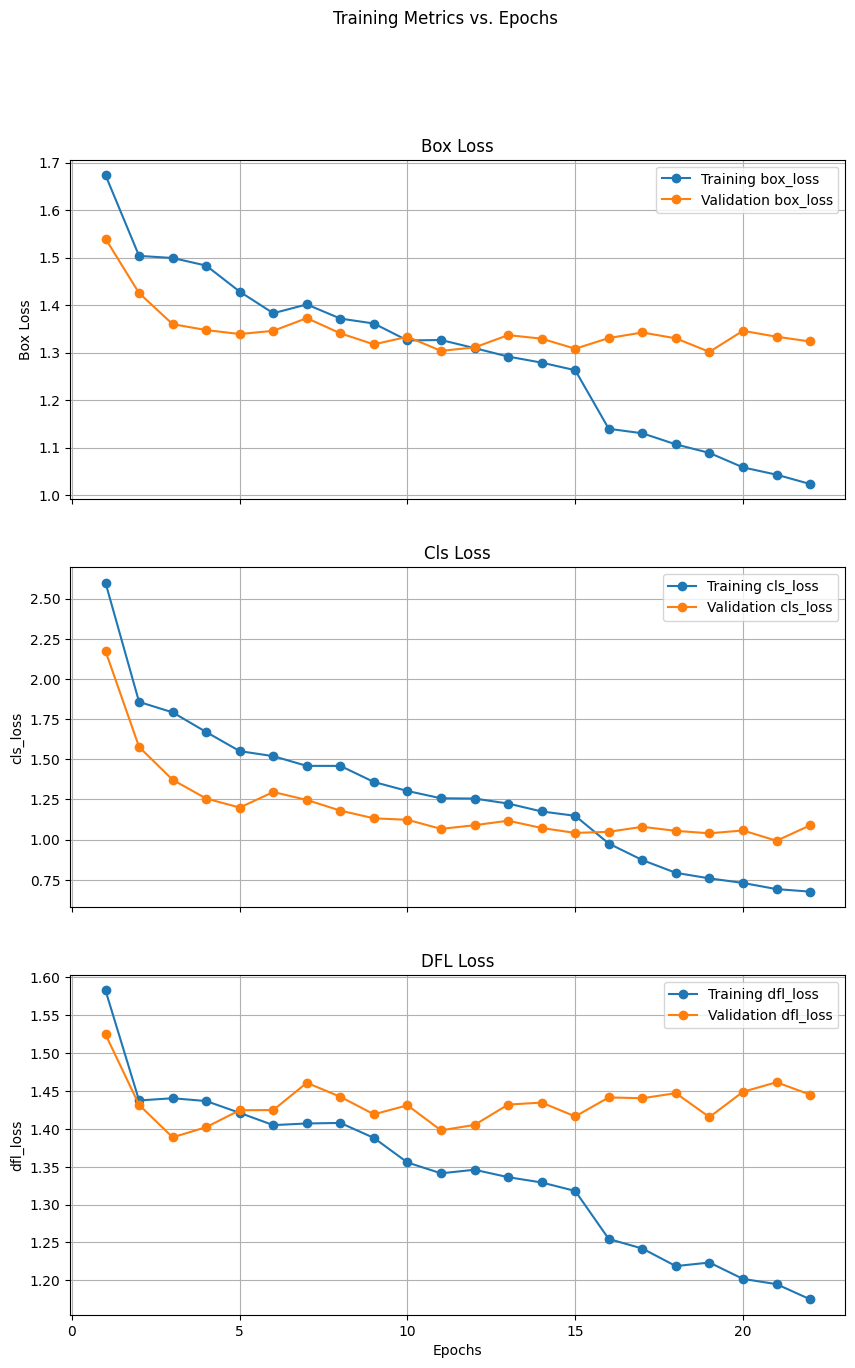

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

### Training and Validation box_loss
ax1.set_title('Box Loss')
ax1.plot(df['epoch'], df['train/box_loss'], label='Training box_loss', marker='o', linestyle='-')
ax1.plot(df['epoch'], df['val/box_loss'], label='Validation box_loss', marker='o', linestyle='-')
ax1.set_ylabel('Box Loss')
ax1.legend()
ax1.grid(True)

### Training and Validation cls_loss
ax2.set_title('Cls Loss')
ax2.plot(df['epoch'], df['train/cls_loss'], label='Training cls_loss', marker='o', linestyle='-')
ax2.plot(df['epoch'], df['val/cls_loss'], label='Validation cls_loss', marker='o', linestyle='-')
ax2.set_ylabel('cls_loss')
ax2.legend()
ax2.grid(True)

### Training and Validation dfl_loss
ax3.set_title('DFL Loss')
ax3.plot(df['epoch'], df['train/dfl_loss'], label='Training dfl_loss', marker='o', linestyle='-')
ax3.plot(df['epoch'], df['val/dfl_loss'], label='Validation dfl_loss', marker='o', linestyle='-')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('dfl_loss')
ax3.legend()
ax3.grid(True)

plt.suptitle('Training Metrics vs. Epochs')
plt.show()

#### Review detection examples on the validation dataset

In [27]:
validation_results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'val_batch' in i
]

len(validation_results_paths)

6

/kaggle/working/runs/detect/yolov9e_ppe_css_25_epochs/val_batch2_labels.jpg


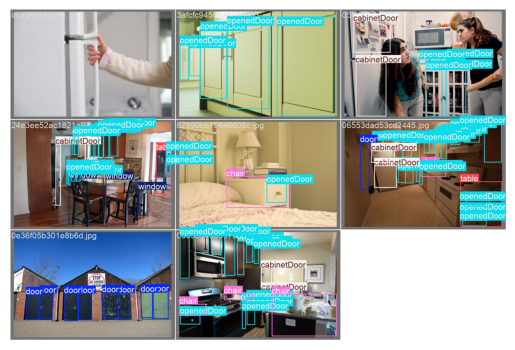

In [28]:
if len(validation_results_paths) >= 1:
    val_img_path = random.choice(validation_results_paths)
    print(val_img_path)
    display_image(val_img_path, print_info = False, hide_axis = True)

## Висновки

#### Аналіз графіків та метрик

**Box Loss** та **Cls Loss**: є позитивна динаміка, так як і тренувальні, і валідаційні втрати знижуються. Тренувальні втрати зменшуються з кожною епохою, що свідчить про те, що модель навчається. Однак, на деяких етапах видно, що валідаційні втрати коливаються. Це може свідчити про незначне перенавчання.

**mAP50** та **mAP50-95**: метрики стабільно покращуються на початку навчання, проте після 11 епохи вони починають коливатися та залишаються приблизно на одному рівні, а іноді і погіршуються. Це свідчить про необхідність додаткових налаштувань та покращень в обробці даних.

Класи **"openedDoor"**, **"cabinetDoor"** та **"window"** мають високу точність і гарні F1-score, що свідчить, що модель добре ідентифікує ці класи. **"pole"** та **"couch"** мають найнижчі показники, що свідчить про те, що модель справляється з ними найгірше. Я впевнена, що це пов'язано з дисбалансом у класах.

**Confusion Matrix**: модель часто плутає такі класи, як **"door"**, **"openedDoor"**, **"cabinetDoor"**. Ці помилки можуть бути пов'язані з тим, що у відкритих дверей і звичайних дверей схожі ознаки (форма, контекст, лінії), тому складно відрізнити, чи є двері відчиненими або закритими, звичайними чи кабінетними. **"cabinet"**, **"couch"** і **"pole"** мають найгірші показники, це пов'язано з з дисбалансом у цих класах. Багато класів модель не відрізняє від **"background"**. Це може свідчити про те, що модель має труднощі з визначенням реальних об'єктів на фоні, бо деякі класи представлені недостатньо або деякі об'єкти можуть бути маленькими на зображеннях, через що модель не встигає їх вірно розпізнати.

#### Результати роботи моделі та рекомендації для покращення моделі

Порівняємо отримані результати з очікуваними:

- **mAP50=46%** і **mAP50-95=30%** досягають базового рівня (40-60% для mAP50 та 25-40% для mAP50-95)
- **Precision** для найпростіших об'єктів класів коливається у межах норми (60-75%)
- **Precision** для складніших об'єктів класів досягає норми (50-65%)
- **Precision** для найскладніших об'єктів класів частково в межах норми (40-55%) і модель майже зовсім не розпізнає малопредставлені класи "cabinet", "pole" і "couch"
- **Recall** для окремих класів частково варіюється від 50% до 70%
- **F1-score** у середньому по всіх класах 43%, що трохи нижче норми 45-60%
- **Загальна точність класифікації** 58% досягає очікуваної 55-70%.

Отже, модель частково досягла очікуваних результатів і доволі добре справляється з ідентифікацією більшості класів, проте має проблеми з розпізнаванням малопредставлених класів.

Рекомендаціями для покращення моделі можуть бути:

- сфокусуватися на проблемних класах: збільшити дані та збалансувати класи
- модифікувати гіперпараметри (я експериментівала з оптимізатором, batch size, learning rate, dropout, label smoothing, кількістю епох, аугментацією)
- спробувати більш складну архітектуру та більш потужну базову модель.